In [1]:
##transformerXl:step by step
#using TRansformer for language Modeling

#transformer XL : summary
#1. Transformer XL is a variant of the transformer model that is designed to handle longer input sequences
#2. It uses a combination of recurrence and self-attention to model long-range dependencies
#3. It uses a novel technique called "segmented recurrence" to process input sequences in chunks
#4. It uses a technique called "relative positional encoding" to encode the position of each token
#5. It uses a technique called " sinusoidal encoding" to encode the position of each token
#6. It uses a technique called "adaptive input embedding" to adapt the input embedding to the
#length of the input sequence
#7. It uses a technique called "layer normalization" to normalize the output of each layer
# 8. It uses a technique called "dropout" to regularize the model
#9. It uses a technique called "weight sharing" to share the weights across different layers
#10. It uses a technique called " sparse attention" to reduce the computational cost of self-
# attention




### importing the libraries

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from keras.models import *
from  keras.layers import *
from keras.datasets import imdb
from keras.utils import pad_sequences

define the transformer  block

In [31]:
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
       #emded_dim :  this paramenter specifies the dimesionaly of input and output
        #num_heads  : this paramentwr control the number of attendation heads in the mul
        #ff_dim : this paramentwr control dimention of the feedforword
        super().__init__()
        self.att = MultiHeadAttention(key_dim=embed_dim,num_heads=num_heads)
        self.ffn = Sequential([Dense(ff_dim, activation="relu") , Dense(embed_dim),])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs , training):
        attn_output = self.att(inputs , inputs)
        # Appiles multi-head attention to input sentence ,allow different part
        attn_output = self.dropout1(attn_output, training=training)
        #dropout to prevent overfitting
        out1 = self.layernorm1(inputs + attn_output)
        #add residual connection
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [32]:

class TokenAndPositionEmbedding(Layer):
        def __init__(self, maxlen, vocab_size, embed_dim):
            super().__init__()
            self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
            self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)
        def call(self, x):
                maxlen = tf.shape(x)[-1]
                positions = tf.range(start=0, limit=maxlen, delta=1)
                positions = self.pos_emb(positions)
                x = self.token_emb(x)
                return x + positions

In [33]:
vocab_size = 20000 # Only consider the top 20k words
max_length = 200 # Only consider the first 100 words of each movie review

In [34]:
(X_train, y_train), (X_val, y_val) = imdb.load_data(num_words=vocab_size)
print(len(X_train), 'train sequences')
print(len(X_val), 'validation sequences')

25000 train sequences
25000 validation sequences


In [35]:
X_train = pad_sequences(X_train, maxlen=max_length)
X_val = pad_sequences(X_val, maxlen=max_length)

In [36]:
X_train.shape

(25000, 200)

In [37]:
embed_dim = 32 # Embedding size for each
num_heads = 2 # Number of attention heads
ff_dim = 32 # Hidden layer size in feed forward network inside transformer

inputs  = Input(shape=(max_length,))
embedding_layer = TokenAndPositionEmbedding(max_length, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(20, activation='relu')(x)
x = Dropout(0.1)(x)
outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)


In [38]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 200)]             0         
                                                                 
 token_and_position_embeddi  (None, 200, 32)           646400    
 ng_5 (TokenAndPositionEmbe                                      
 dding)                                                          
                                                                 
 transformer_block_5 (Trans  (None, 200, 32)           10656     
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_4  (None, 32)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_18 (Dropout)        (None, 32)                0   

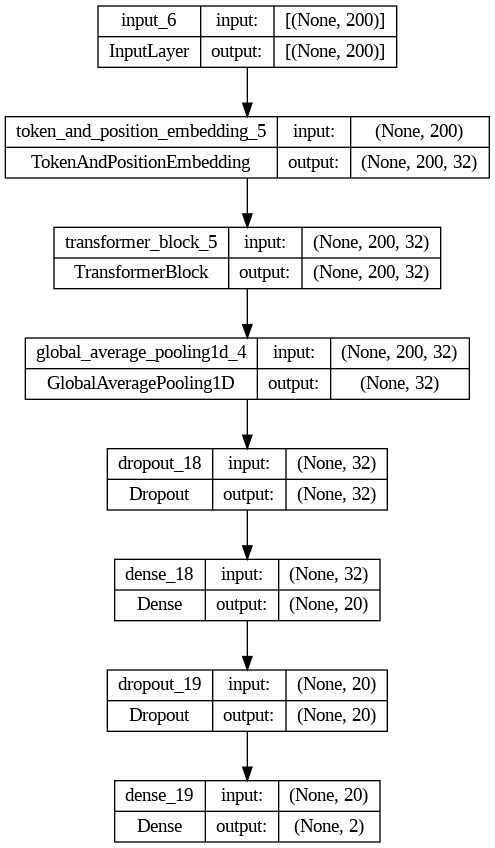

In [39]:
from keras.utils import plot_model
plot_model(model, show_shapes=True)

Compile Model

In [40]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [41]:
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
782/782 [==============================] - 142s 177ms/step - loss: 0.3763 - accuracy: 0.8230 - val_loss: 0.2921 - val_accuracy: 0.8766
Epoch 2/10
782/782 [==============================] - 144s 184ms/step - loss: 0.2030 - accuracy: 0.9226 - val_loss: 0.3901 - val_accuracy: 0.8417
Epoch 3/10
782/782 [==============================] - 143s 183ms/step - loss: 0.1360 - accuracy: 0.9513 - val_loss: 0.3966 - val_accuracy: 0.8625
Epoch 4/10
782/782 [==============================] - 133s 170ms/step - loss: 0.0906 - accuracy: 0.9689 - val_loss: 0.4330 - val_accuracy: 0.8572
Epoch 5/10
782/782 [==============================] - 129s 165ms/step - loss: 0.0626 - accuracy: 0.9790 - val_loss: 0.6129 - val_accuracy: 0.8462
Epoch 6/10
782/782 [==============================] - 126s 162ms/step - loss: 0.0464 - accuracy: 0.9859 - val_loss: 0.7246 - val_accuracy: 0.8442
Epoch 7/10
782/782 [==============================] - 127s 163ms/step - loss: 0.0340 - accuracy: 0.9894 - val_loss: 0.6937 -

Predivcting the unseen data